In [1]:
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.figsize'] = [12, 8]

In [139]:
plt.style.use('plot_style.txt')


Bad key "axes.titlelocation" on line 28 in
plot_style.txt.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [107]:
from matplotlib.ticker import ScalarFormatter,AutoMinorLocator

In [12]:
import itertools

In [434]:
import re

In [16]:
import utilities as u
import best

In [2]:
import numpy as np

In [49]:
import pandas

In [3]:
import pathlib

In [4]:
import yaml

In [5]:
values_file = 'configurations/configILC.yaml'
with open(values_file, 'r') as stream:
            data = yaml.safe_load(stream)
values_file

'configurations/configILC.yaml'

In [13]:
plots_directory = data['plotsdirectory']

analysis_directory = data['analysisdirectory']

savingdirectory = data['savingdirectory']

Nsims = data['Nsims']

results_directory = data['resultsdirectory']
spectra_path = data['spectra_path']
sims_directory = data['sims_directory']
WR = u.write_read(sims_directory)

PP = pathlib.Path(analysis_directory)
Pplots = pathlib.Path(plots_directory)

fgnamefiles = data['fgnamefiles']

estimators_dictionary = data['estimators']
estimators = list(estimators_dictionary.keys())

#### List of estimators here

In [389]:
estimatorssub = data['estimatorssubset']
estimatorssub = ['shear', 'bh', 'pbh', 'symm']

In [429]:
if estimatorssub != '':
    estimators = estimatorssub

lista_lmaxes = []

names = {}

labeling = {}

for e in estimators:
    elemento = estimators_dictionary[e]
    names[e] = elemento['direc_name']
    labeling[e] = elemento['label']
    lmax_min, lmax_max = elemento['lmax_min'], elemento['lmax_max']
    num = elemento['number']
    lista_lmaxes += [np.linspace(lmax_min, lmax_max, num, dtype = int)]

lmaxes_configs = list(itertools.product(*lista_lmaxes))


#CHOOSE nu
nu = estimators_dictionary[estimators[0]]['nu']

lmin_sel, lmax_sel = data['lmin_sel'], data['lmax_sel']

optversion = data['optversion']

In [391]:
officialname = ''
for e in estimatorssub:
    officialname += f'{e}' 

In [392]:
outputofficial = pathlib.Path('officialplotspaper/')
output_plots = outputofficial/officialname
pathlib.Path(output_plots).mkdir(parents = True, exist_ok = False)

## OPTIMISATION SECTION

### OPTIMISATION RESULTS FOR SET A

#### Setting the reference case for HUOK 3500

In [393]:
lref_ = 3500
reference_directory = pathlib.Path('output_ILC_1503')/f'h{lref_}s{lref_}b{lref_}p{lref_}sy{lref_}sybh{lref_}/total/'

kk = np.load(reference_directory/'kk_total_ilc.npy')
theta = np.load(reference_directory/'theta_total_ilc.npy')
ells = np.load(reference_directory/'ells_total_ilc.npy')
selection = (ells > 30) & (ells < 1200)
biases = np.load(reference_directory/'totalbias_total_ilc.npy')
noises_high = np.load(reference_directory/'N_total_ilc.npy')
estimators_reference = ['h', 's', 'b', 'p', 'sy', 'sybh']
Optimizerkk_high = best.Opt(estimators_reference, lmin_sel, lmax_sel, ells, kk, theta, biases, noises_high)


filtbiases = Optimizerkk_high.filter_(abs(Optimizerkk_high.biases_selected), sigma = 1.5)
Optimizerkk_high_filt = best.Opt(estimators_reference, lmin_sel, lmax_sel, Optimizerkk_high.ells_selected, Optimizerkk_high.theory_selected, Optimizerkk_high.theta_selected, filtbiases, Optimizerkk_high.noises_selected)  

In [461]:
fnb_getter = lambda Opt, fb_val, invvar: Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected,
                              sum_biases_squared = False, bias_squared = False, fb = fb_val, inv_variance = invvar, analytical = True)

def get_est_weights(Opt, index):
    '''
    index = 0, 1, ....
    e.g. h, s, b -> index = 1 gives s
    '''
    Nest = len(Opt.estimators)
    nbins = Opt.nbins
    zeros = np.zeros(Nest*nbins)
    for j in range(nbins):
        zeros[index+Nest*j:index+(Nest*j+1)] = 1.
    return zeros

def get_dir_function(names):
    def get_dir_(*vals):
        stringa = ''
        for i, k in enumerate(names.keys()):
            num = vals[i]
            v = names[k]
            stringa += f'{v}{num}'
        return stringa
    return get_dir_


def get_info(directory, resultspath, fb = 1.0):
    kk = np.load(pathlib.Path(analysis_directory)/directory/'kk_ilc.npy')
    theta = np.load(pathlib.Path(analysis_directory)/directory/'theta_ilc.npy')
    ells = np.load(pathlib.Path(analysis_directory)/directory/'ells_ilc.npy')
    selection = (ells > 30) & (ells < 1200)
    biases = np.load(pathlib.Path(analysis_directory)/directory/'total/totalbias_total_ilc.npy')
    noises = np.load(pathlib.Path(analysis_directory)/directory/'total/N_total_ilc.npy')
    w = np.load(resultspath/directory/f'w_auto_fb_{fb}.npy')
    x = np.load(resultspath/directory/f'x_auto_fb_{fb}.npy')
    return kk, theta, ells, biases, noises, w, x


def make_table(resultsdir, all_lmaxes_directories, names, fb = 0., crosstag = None, optimtag = None, all_ref = None, autoname = 'Auto', include_estimators = True, include_dirs = True, include_ref = False, extradir = ''):
    data = {}
    if include_dirs:
        data['Name'] = all_lmaxes_directories
    superarray = np.zeros((3, 1+len(names), len(all_lmaxes_directories)))
    for i, direc in enumerate(all_lmaxes_directories):
        try:
            results_array = np.load(resultsdir/direc/extradir/f'alens_{fb}{crosstag}{optimtag}.npy')
            superarray[:, :, i] = results_array
        except:
            print(f'Skip {direc} for {fb}')
        
    data[f'Total {autoname}'] = superarray[0, 0]
    data[f'Noise {autoname}'] = superarray[1, 0]
    data[f'Bias {autoname}'] = superarray[2, 0]
    
    if include_ref:
        data[f'Noise {autoname} rtr'] = superarray[1, 0]/all_ref[1]
        data[f'Bias {autoname} rtr'] = superarray[2, 0]/all_ref[2]
        
    if include_estimators:
        for i, n in enumerate(names):
            #data[f'Total {n} rtr'] = superarray[0, i]/all_ref[0]
            data[f'Noise {n} rtr'] = superarray[1, i]/all_ref[1]
            data[f'Bias {n} rtr'] = superarray[2, i]/all_ref[2]
    
    return pandas.DataFrame(data)




In [395]:
x_estimator = get_est_weights(Optimizerkk_high, index = 0)
f, n, b = fnb_getter(Optimizerkk_high, 1., True)
f_ref, n_ref, b_ref = f(x_estimator), n(x_estimator), b(x_estimator)
all_ref = [f_ref, n_ref, b_ref]

In [396]:
all_ref

[0.0008459729944576088, 0.006859550712226799, 0.02826516510625752]

In [397]:
x_estimator = get_est_weights(Optimizerkk_high_filt, index = 0)
f, n, b = fnb_getter(Optimizerkk_high_filt, 1., True)
f_ref_filt, n_ref_filt, b_ref_filt = f(x_estimator), n(x_estimator), b(x_estimator)
all_ref_filt = [f_ref_filt, n_ref_filt, b_ref_filt]

In [398]:
all_ref_filt

[0.006031702179245355, 0.006859550712226799, 0.07736051152410862]

In [399]:
get_dir = get_dir_function(names)

In [400]:
names

{'shear': 's', 'bh': 'b', 'pbh': 'p', 'symm': 'sy'}

In [401]:
fbs = data['optimisation']['fbs']
fbs = np.sort(fbs, ).astype(float)
data['optimisation']['fbs']

[0, 0.1, 0.154, 1.0, 4, 9.0, 16.0]

In [402]:
fbs = np.array([0, 0.1, 1.0, 4, 9.0, 16.0])
fbs

array([ 0. ,  0.1,  1. ,  4. ,  9. , 16. ])

In [403]:
import matplotlib.cm as cm
colors_plotting = cm.rainbow(np.linspace(0, 1, len(fbs)))

#### Looking for the best configuration

In [404]:
invvariance = False
if invvariance:
    inv_variance_dir = 'inversevariance'
else:
    inv_variance_dir = ''

In [405]:
nocross = False
crosstag = '_nocross' if nocross else ''

optim = True
optimtag = '_ofoptim' if optim else ''

if (nocross and optim):
    precisetitle = 'no cross, with filt abs'
elif (nocross and not optim):
    precisetitle = 'no cross'
elif (not nocross and optim):
    precisetitle = 'with cross, with filt abs'
elif (not nocross and not optim):
    precisetitle = 'with cross'

In [406]:
dd = {}
dd['Name'] = 'HUOK3500'
dd['Total Auto'] = all_ref[0]
dd['Noise Auto'] = all_ref[1]
dd['Bias Auto'] = all_ref[2]

In [407]:
resultspath = pathlib.Path(results_directory)

In [408]:
path = pathlib.Path(results_directory)
l = 3500
lista = [l for e in estimators]
all_lmaxes_directories=  [x.name for x in path.iterdir() if x.is_dir() and len(x.name)==len(get_dir(*lista))]

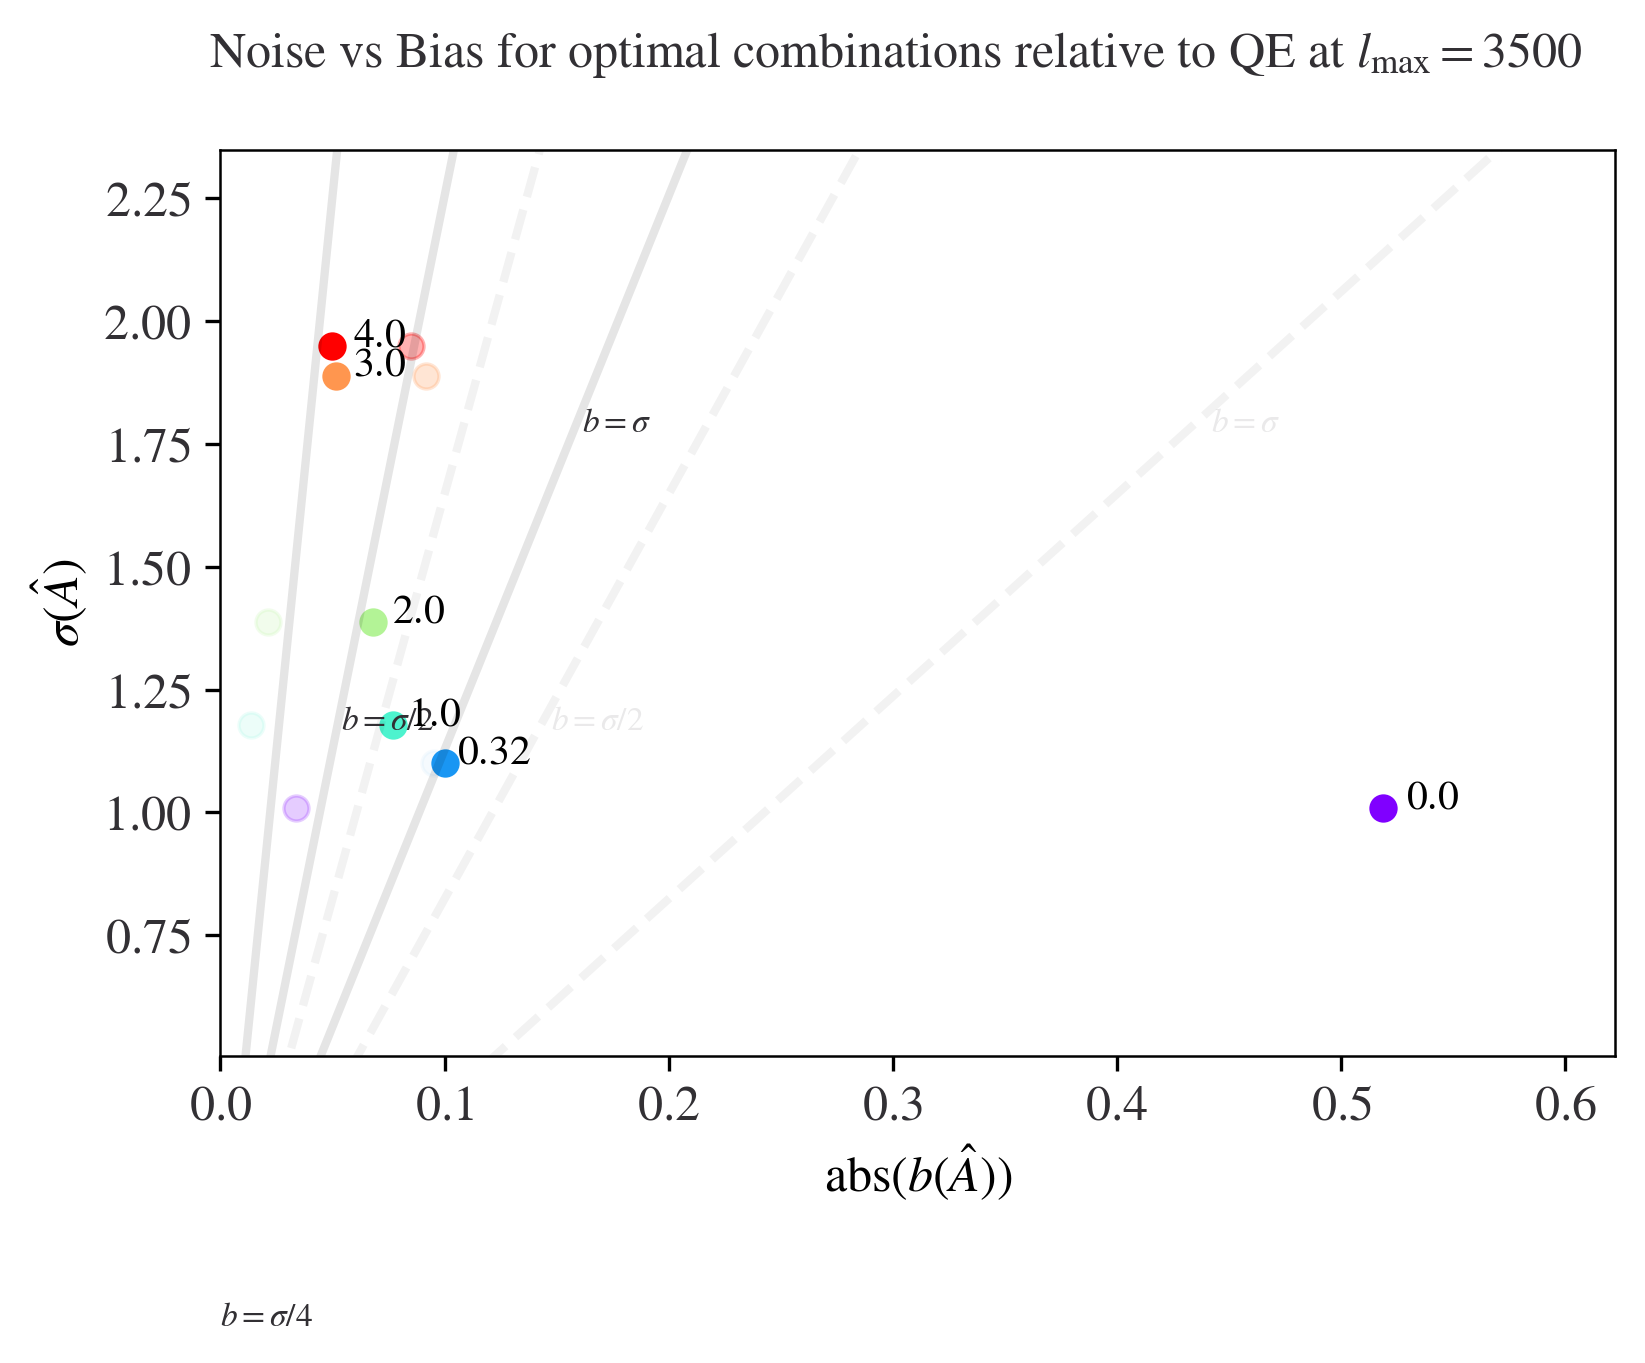

In [418]:
ns = np.array([])
bs = np.array([])
fs = np.array([])

ns_no_filt = np.array([])
bs_no_filt = np.array([])
fs_no_filt = np.array([])

all_best_direcs = []

names_W = list(names)+['$W_L$']
names_W

for ii, fb in enumerate(fbs):
    d = make_table(resultspath, all_lmaxes_directories, ['S', 'BH', 'PH', 'SYMM'], fb = fb, crosstag = crosstag, optimtag = optimtag, include_estimators = False, extradir = inv_variance_dir)
    
    dref = make_table(resultspath, all_lmaxes_directories, ['S', 'BH', 'PH', 'SYMM'], fb = fb, crosstag = crosstag, optimtag = optimtag, all_ref = all_ref,
                      include_estimators = False, extradir = inv_variance_dir, include_ref = True)

    Ntop = 5
    
    top5 = list(d.sort_values(by = 'Total Auto').head(Ntop).iloc[:Ntop, 0])
    
    direc = d.sort_values(by = 'Total Auto').head(1).iloc[0, 0]

    lmax_directory = direc
    
    all_best_direcs += [direc]
    
    kk, theta, ells, biases, noises, w, x = get_info(direc, resultspath, fb = fb)
    Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, (biases), noises, nocrosses = nocross)
    
    if optim:
        filtbiases = Optimizerkk.filter_(abs(Optimizerkk.biases_selected), sigma = 1.5)
        Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, Optimizerkk.ells_selected, Optimizerkk.theory_selected, Optimizerkk.theta_selected, filtbiases, Optimizerkk.noises_selected)              
                  
                  
    resultkk = best.Res()
    f, n, b = fnb_getter(Optimizerkk, fb_val = fb, invvar = invvariance)
    resultkk.load_all(resultspath/lmax_directory/inv_variance_dir, f'auto_fb_{fb}{crosstag}')
    
    results_array = np.load(resultspath/direc/f'alens_{fb}{crosstag}{optimtag}.npy')[:, 0]
    ftemp, ntemp, btemp = results_array
    
    ns = np.append(ns, ntemp)
    bs = np.append(bs, btemp)
    fs = np.append(fs, ftemp)
    
    
    results_array = np.load(resultspath/direc/f'alens_{fb}{crosstag}.npy')[:, 0]
    ftemp, ntemp, btemp = results_array
    
    ns_no_filt = np.append(ns_no_filt, ntemp)
    bs_no_filt = np.append(bs_no_filt, btemp)
    fs_no_filt = np.append(fs_no_filt, ftemp)
    
    smallns = []
    smallbs = []
    for temp_lmax_directory in top5:
        results_array = np.load(resultspath/temp_lmax_directory/f'alens_{fb}{crosstag}{optimtag}.npy')[:, 0]
        ftemp, ntemp, btemp = results_array
        
        smallns += [ntemp]
        smallbs += [btemp]
        
    smallbs = np.array(smallbs)
    smallns = np.array(smallns)
        
    '''
    fig, ax = plt.subplots(figsize = (10, 10))
    fbname = np.sqrt(fb)
    fig.suptitle(f'Top five for fb = {fbname}, case of {precisetitle}')
    ax.set_ylabel('$\\sigma(\hat{A})$', size = 20)
    ax.set_xlabel('$abs(b(\hat{A}))$', size = 20)
    for i, c in enumerate(zip(abs(smallbs), smallns)):
        b, n = c
        ax.scatter(b, n, color = colors_plotting[i], label = top5[i])
    ax.legend()
    ax.axvline(0., ymin = 0, ymax = 1)
    fbname = np.sqrt(fb)
    #fig.savefig(plotsout/f'top5_for_{fbname}{crosstag}{optimtag}.png', bbox_inches = 'tight', dpi = 300)
    plt.show()  
    '''
     
    
fig, ax = plt.subplots()
fig.suptitle(f'Case of {precisetitle}')
fig.suptitle('Noise vs Bias for optimal combinations relative to QE at $l_{\mathrm{max}}=3500$')
ax.set_ylabel('$\\sigma(\hat{A})$')
ax.set_xlabel('$\mathrm{abs}(b(\hat{A}))$')

alpha = 0.1

cases = [1, 2, 4]
for c in cases:
    
    xmax = max(max(bs/b_ref_filt)*(1+0.2), max(bs_no_filt/b_ref)*(1+0.2))
    
    xx = np.linspace(0, xmax, 300)/b_ref_filt
    yy = c*xx/n_ref_filt*b_ref_filt
    rad = np.arctan(c)
    angledeg = np.rad2deg(rad)
    
    
    
    text = '' if c == 1 else f'/{c}'
    
    ymax = max(max(ns/n_ref_filt)*(1+0.2), max(ns_no_filt/n_ref)*(1+0.2))
    
    bb = max(yy[ (yy<=ymax)][:-1])
    aa = xx[bb==yy]

    ax.text(aa, bb,  '$b=\sigma$'+f'${{{text}}}$', ha="left", va="top", size = 8)
    ax.plot(xx, yy, lw = 2, color = 'black', alpha = alpha)
    
    
    
    xx = np.linspace(0, xmax, 300)/b_ref
    yy = c*xx/n_ref*b_ref
    rad = np.arctan(c)
    angledeg = np.rad2deg(rad)
    text = '' if c == 1 else f'/{c}'
    ymax = max(max(ns/n_ref_filt)*(1+0.2), max(ns_no_filt/n_ref)*(1+0.2))
    bb = max(yy[ (yy<=ymax)][:-1])
    aa = xx[bb==yy]
    ax.text(aa, bb,  '$b=\sigma$'+f'${{{text}}}$', ha="left", va="top", size = 8, alpha = alpha)
    ax.plot(xx, yy, lw = 2, color = 'black', alpha = alpha/2, ls = '--')



for i, c in enumerate(zip(abs(bs)/b_ref_filt, ns/n_ref)):
    b, n = c
    ax.scatter(b, n, color = colors_plotting[i])#, label = all_best_direcs[i])
    
    ax.scatter((abs(bs_no_filt)/b_ref)[i], (ns/n_ref)[i], color = colors_plotting[i], alpha = alpha*2)
    
    fbname = np.round(np.sqrt(fbs[i]), 2)
    text = f'{fbname}, b = {round(b, 4)}, n = {round(n, 4)}, brthuok3500 = {round(b/b_ref_filt, 4)}, nrthuok3500 = {round(n/n_ref, 4)}'
    text = f'${fbname}$'
    alpha = 0.2*i/len(fbs)+0.02
    ax.annotate(text, (b*(1+alpha), n), color = 'black')
    

#ax.legend()
ymax = max(max(ns/n_ref_filt)*(1+0.2), max(ns_no_filt/n_ref)*(1+0.2))
ymin = min(min(ns/n_ref_filt)*(1-0.5), min(ns_no_filt/n_ref)*(1-0.5))
ax.set_ylim(ymin, ymax)


xmax = max(max(bs/b_ref_filt)*(1+0.2), max(bs_no_filt/b_ref)*(1+0.2))
ax.set_xlim(0, xmax = xmax)

fig.savefig(output_plots/'optimalcombstrend.png')
plt.show()  

### Looking for the best

In [420]:
relevant_directorties = all_best_direcs
colors = ['red', 'green', 'purple', 'yellow']
names_W = list(names)+['$W_L$']
names_W

['shear', 'bh', 'pbh', 'symm', '$W_L$']

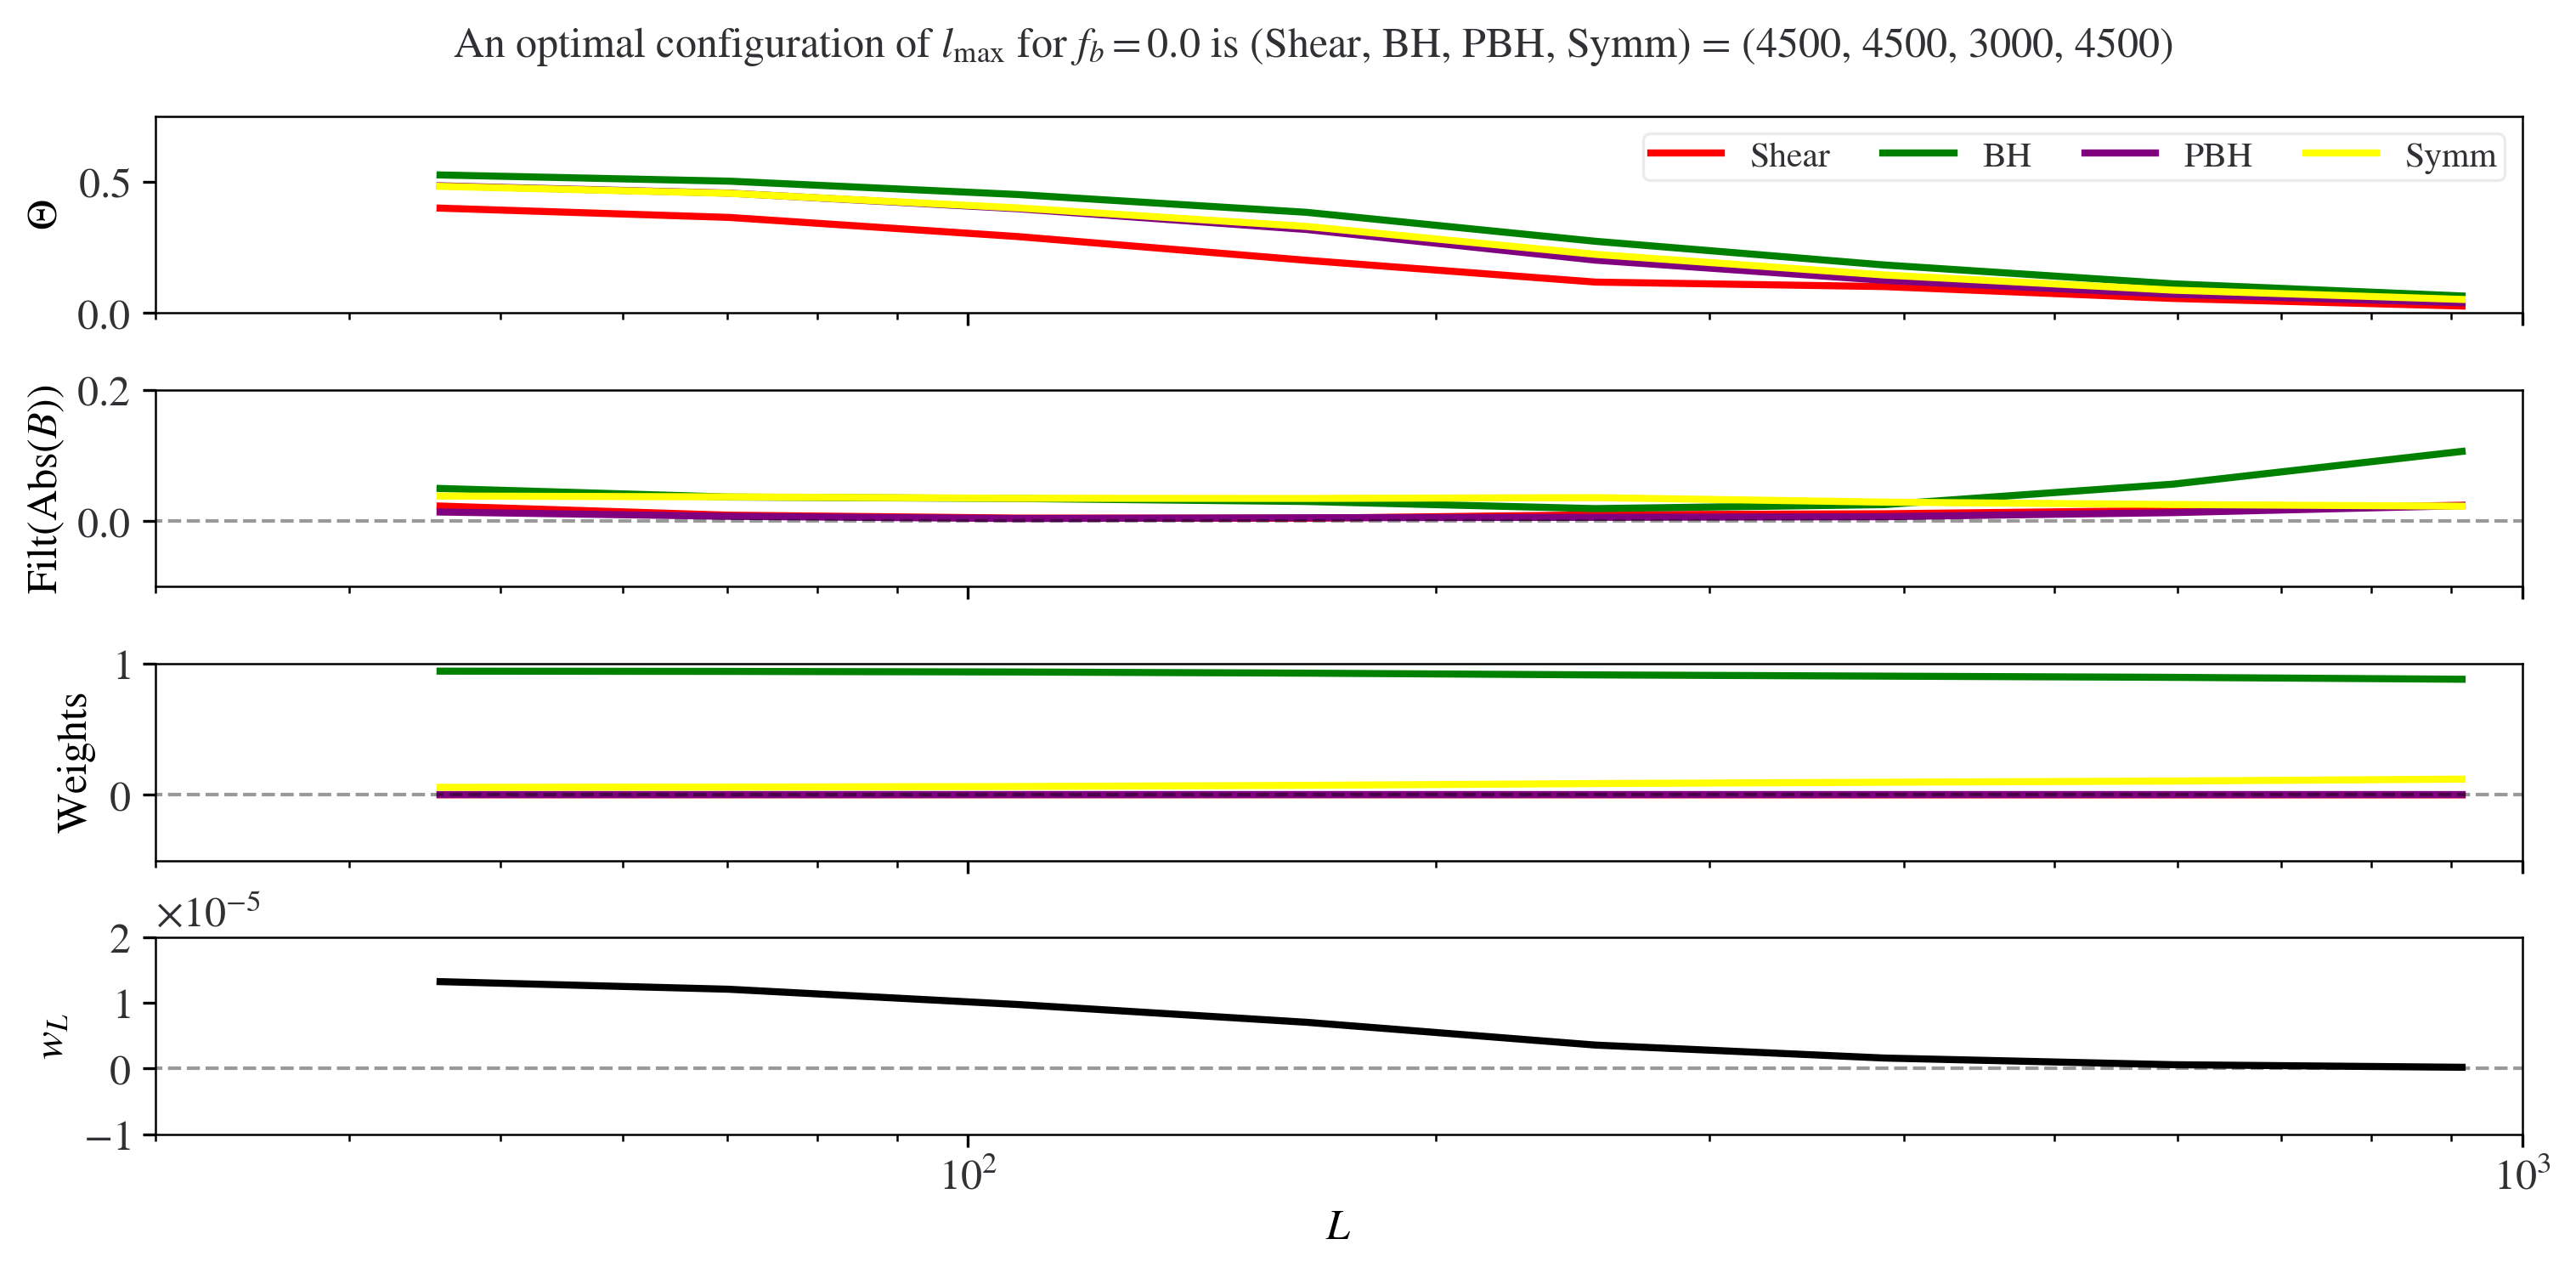

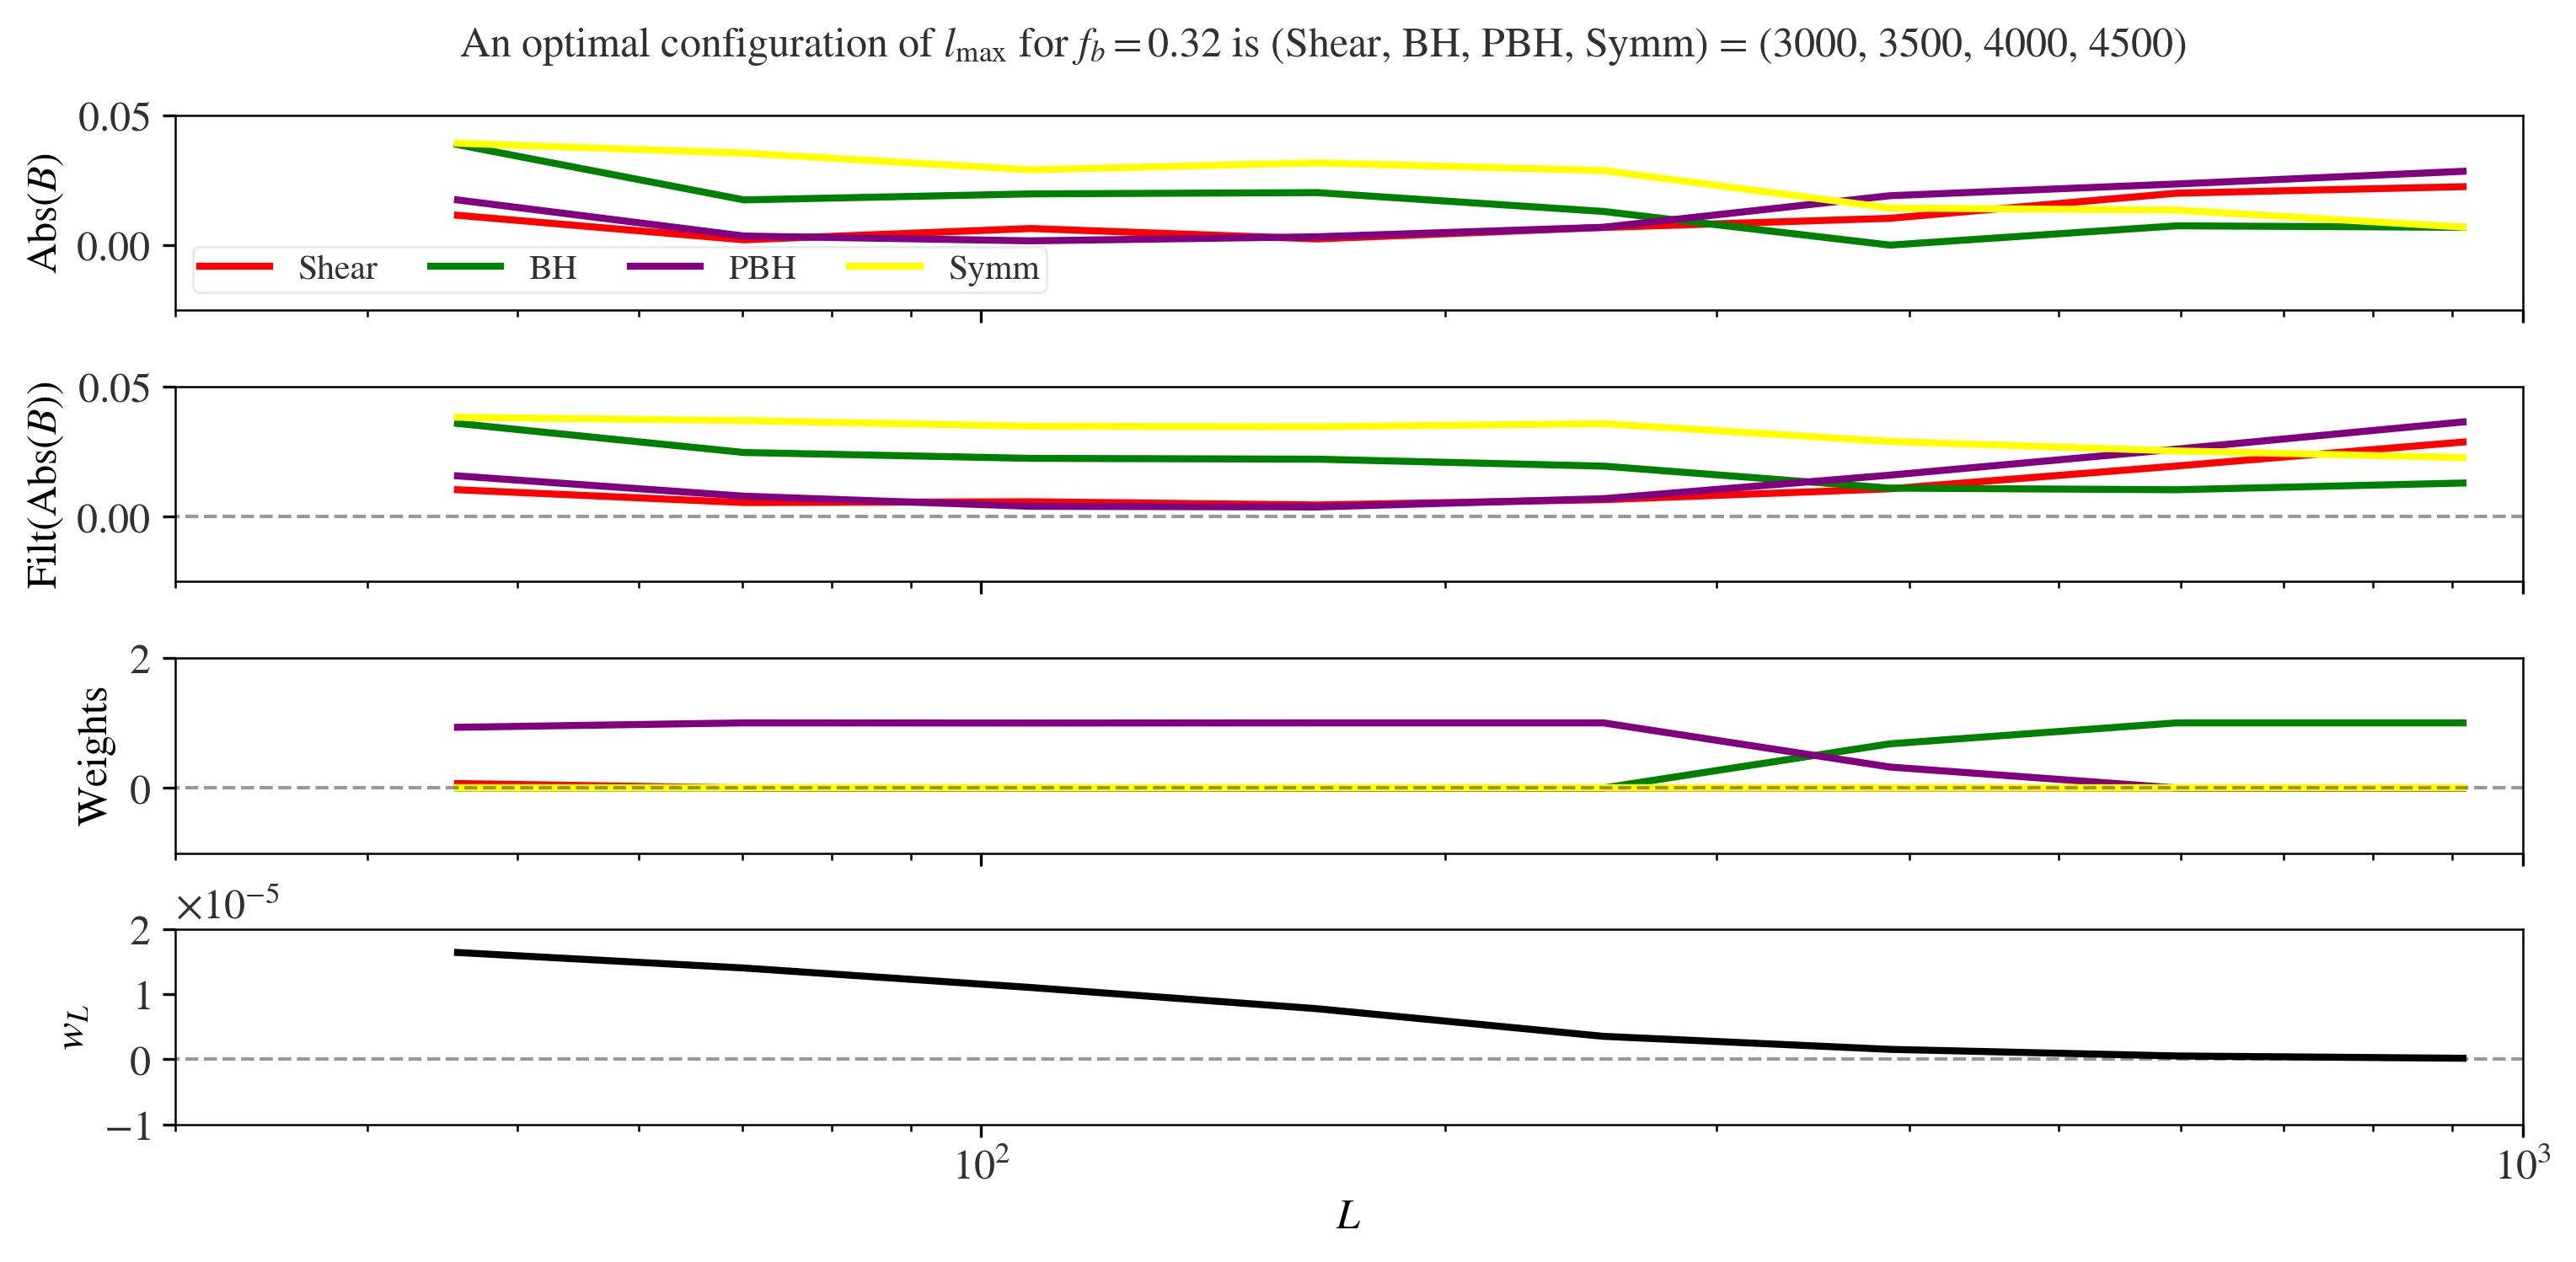

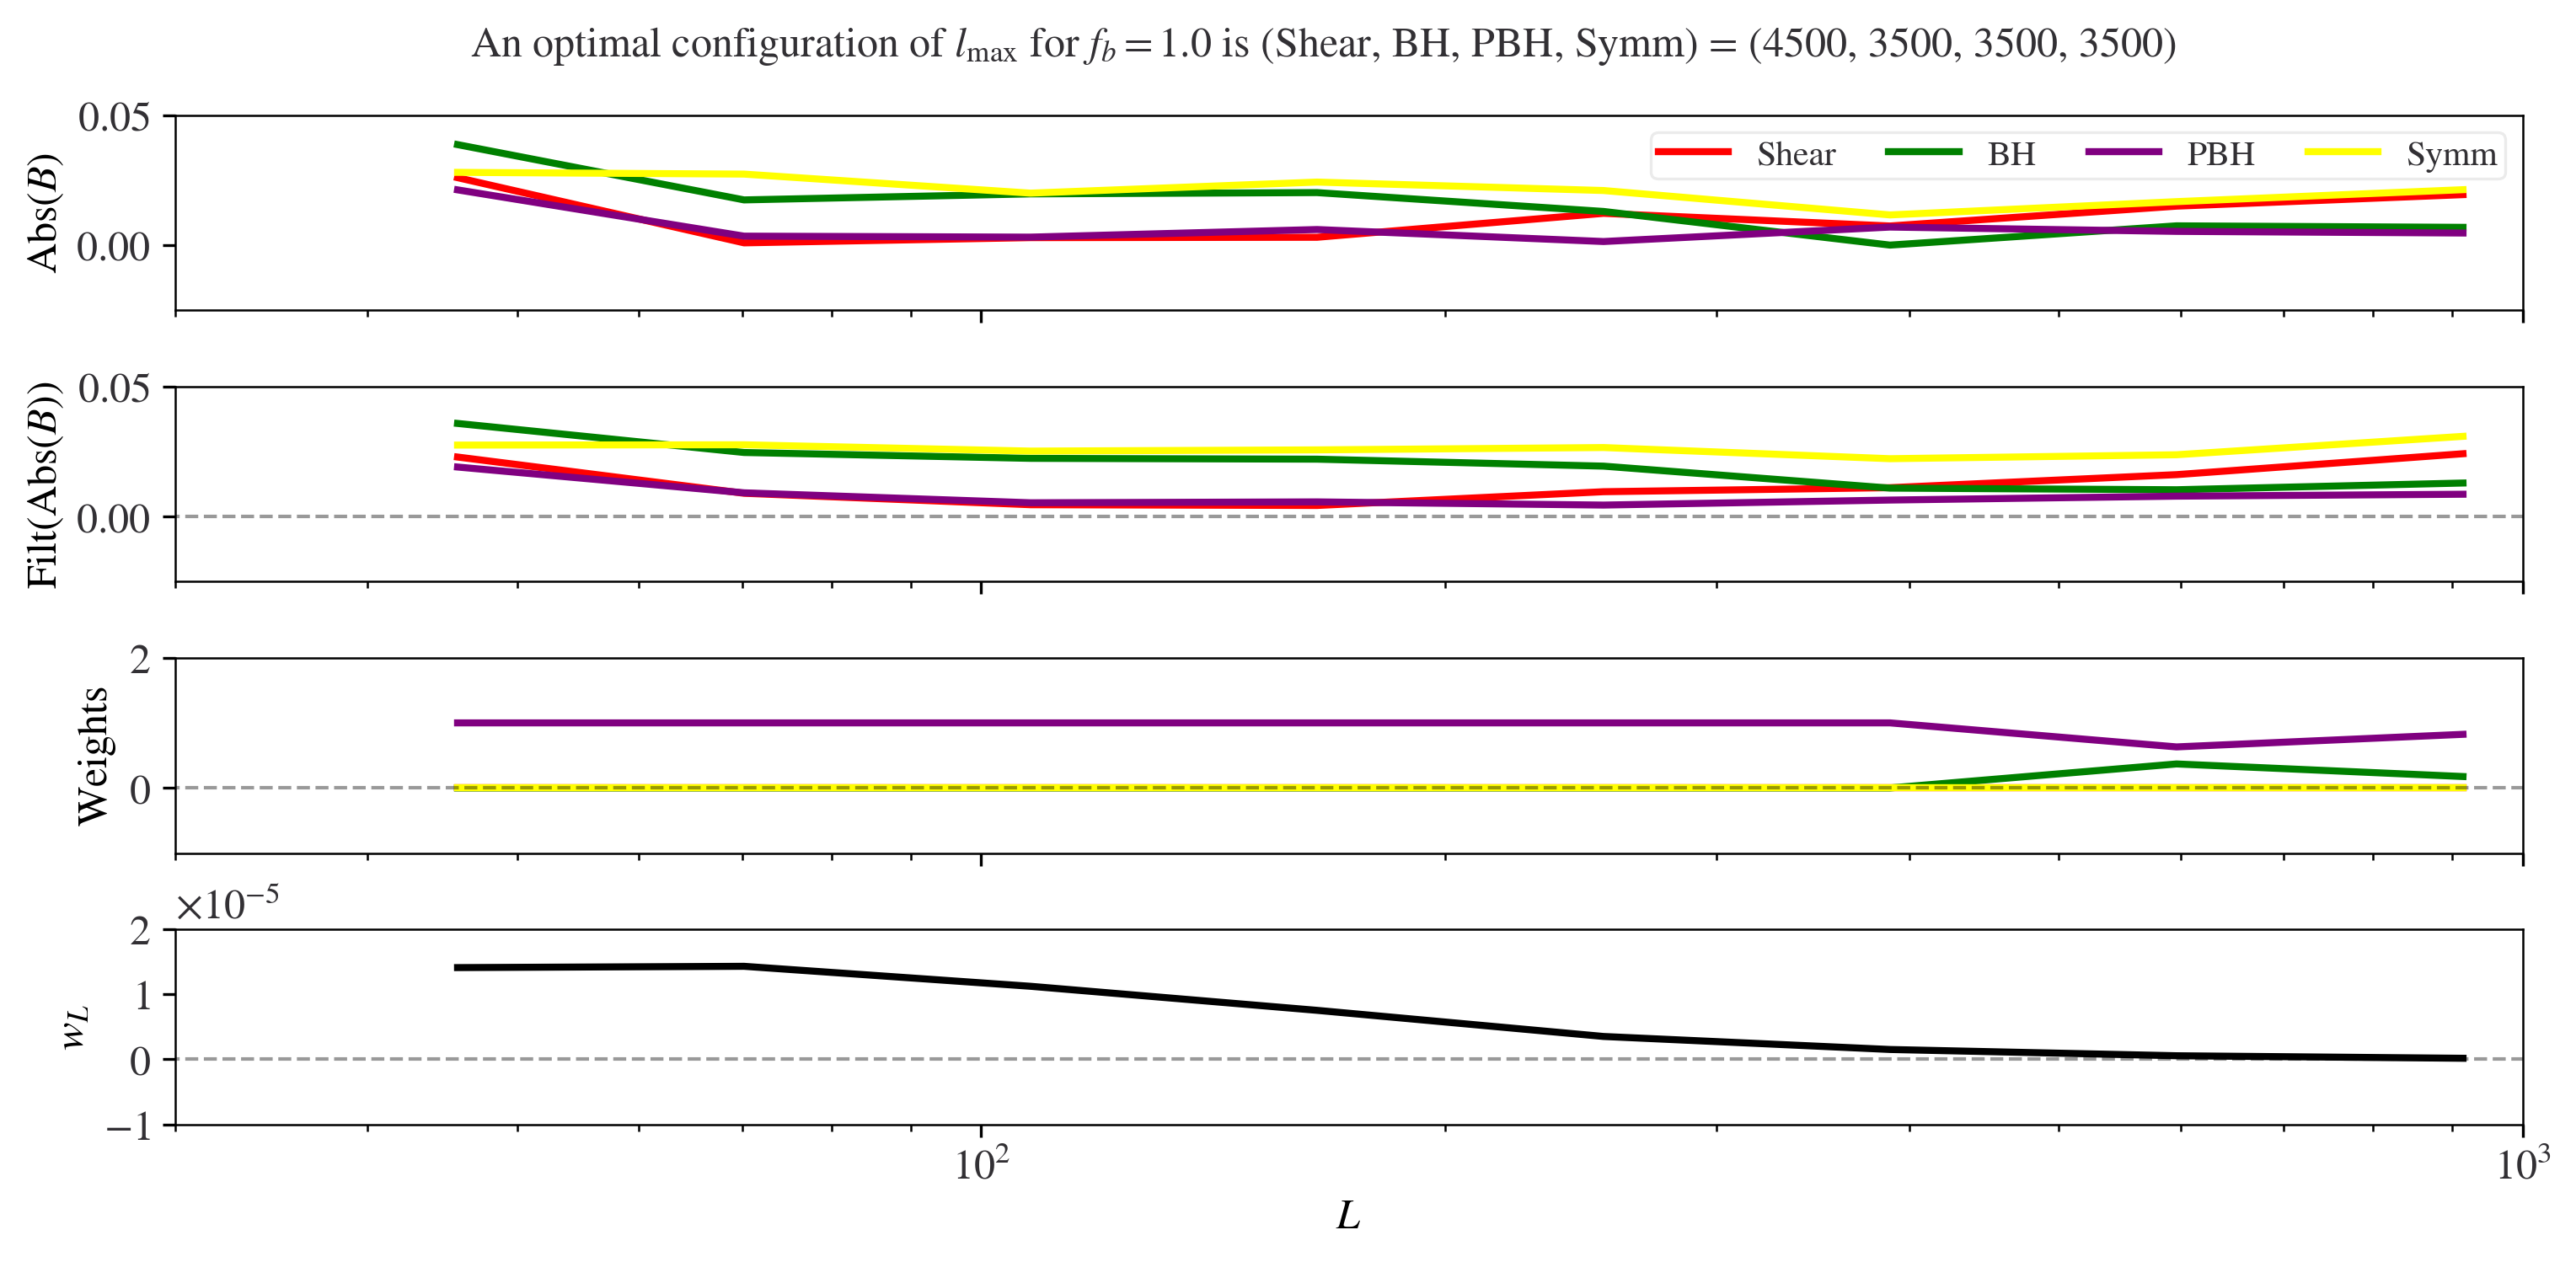

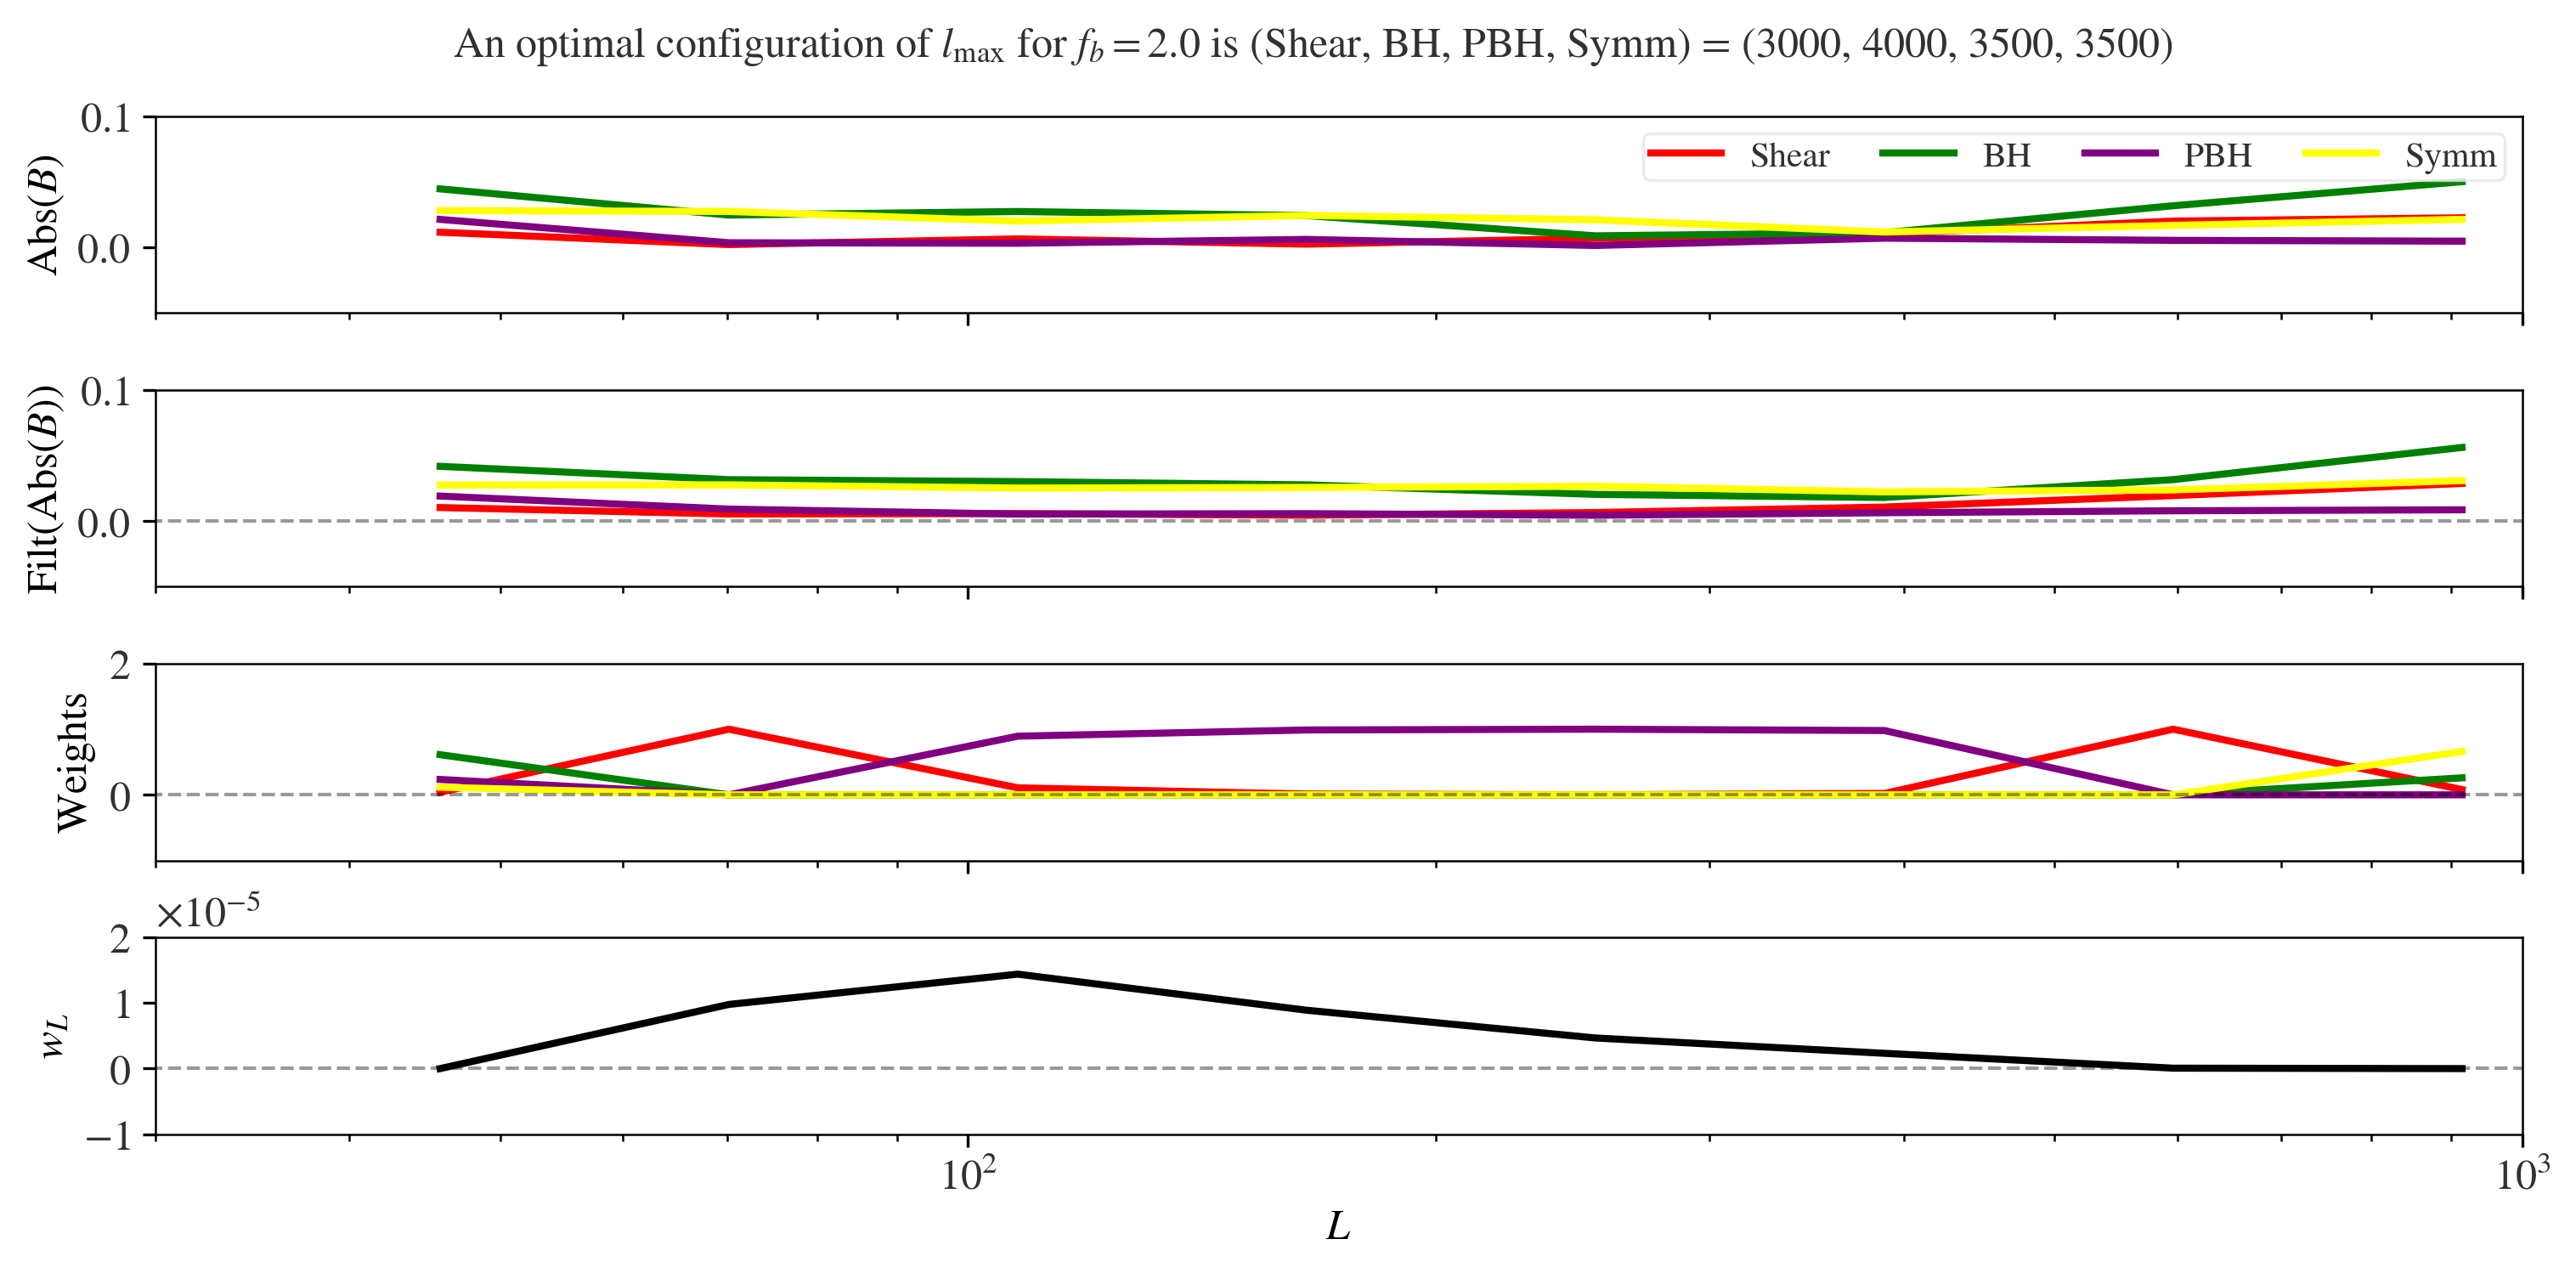

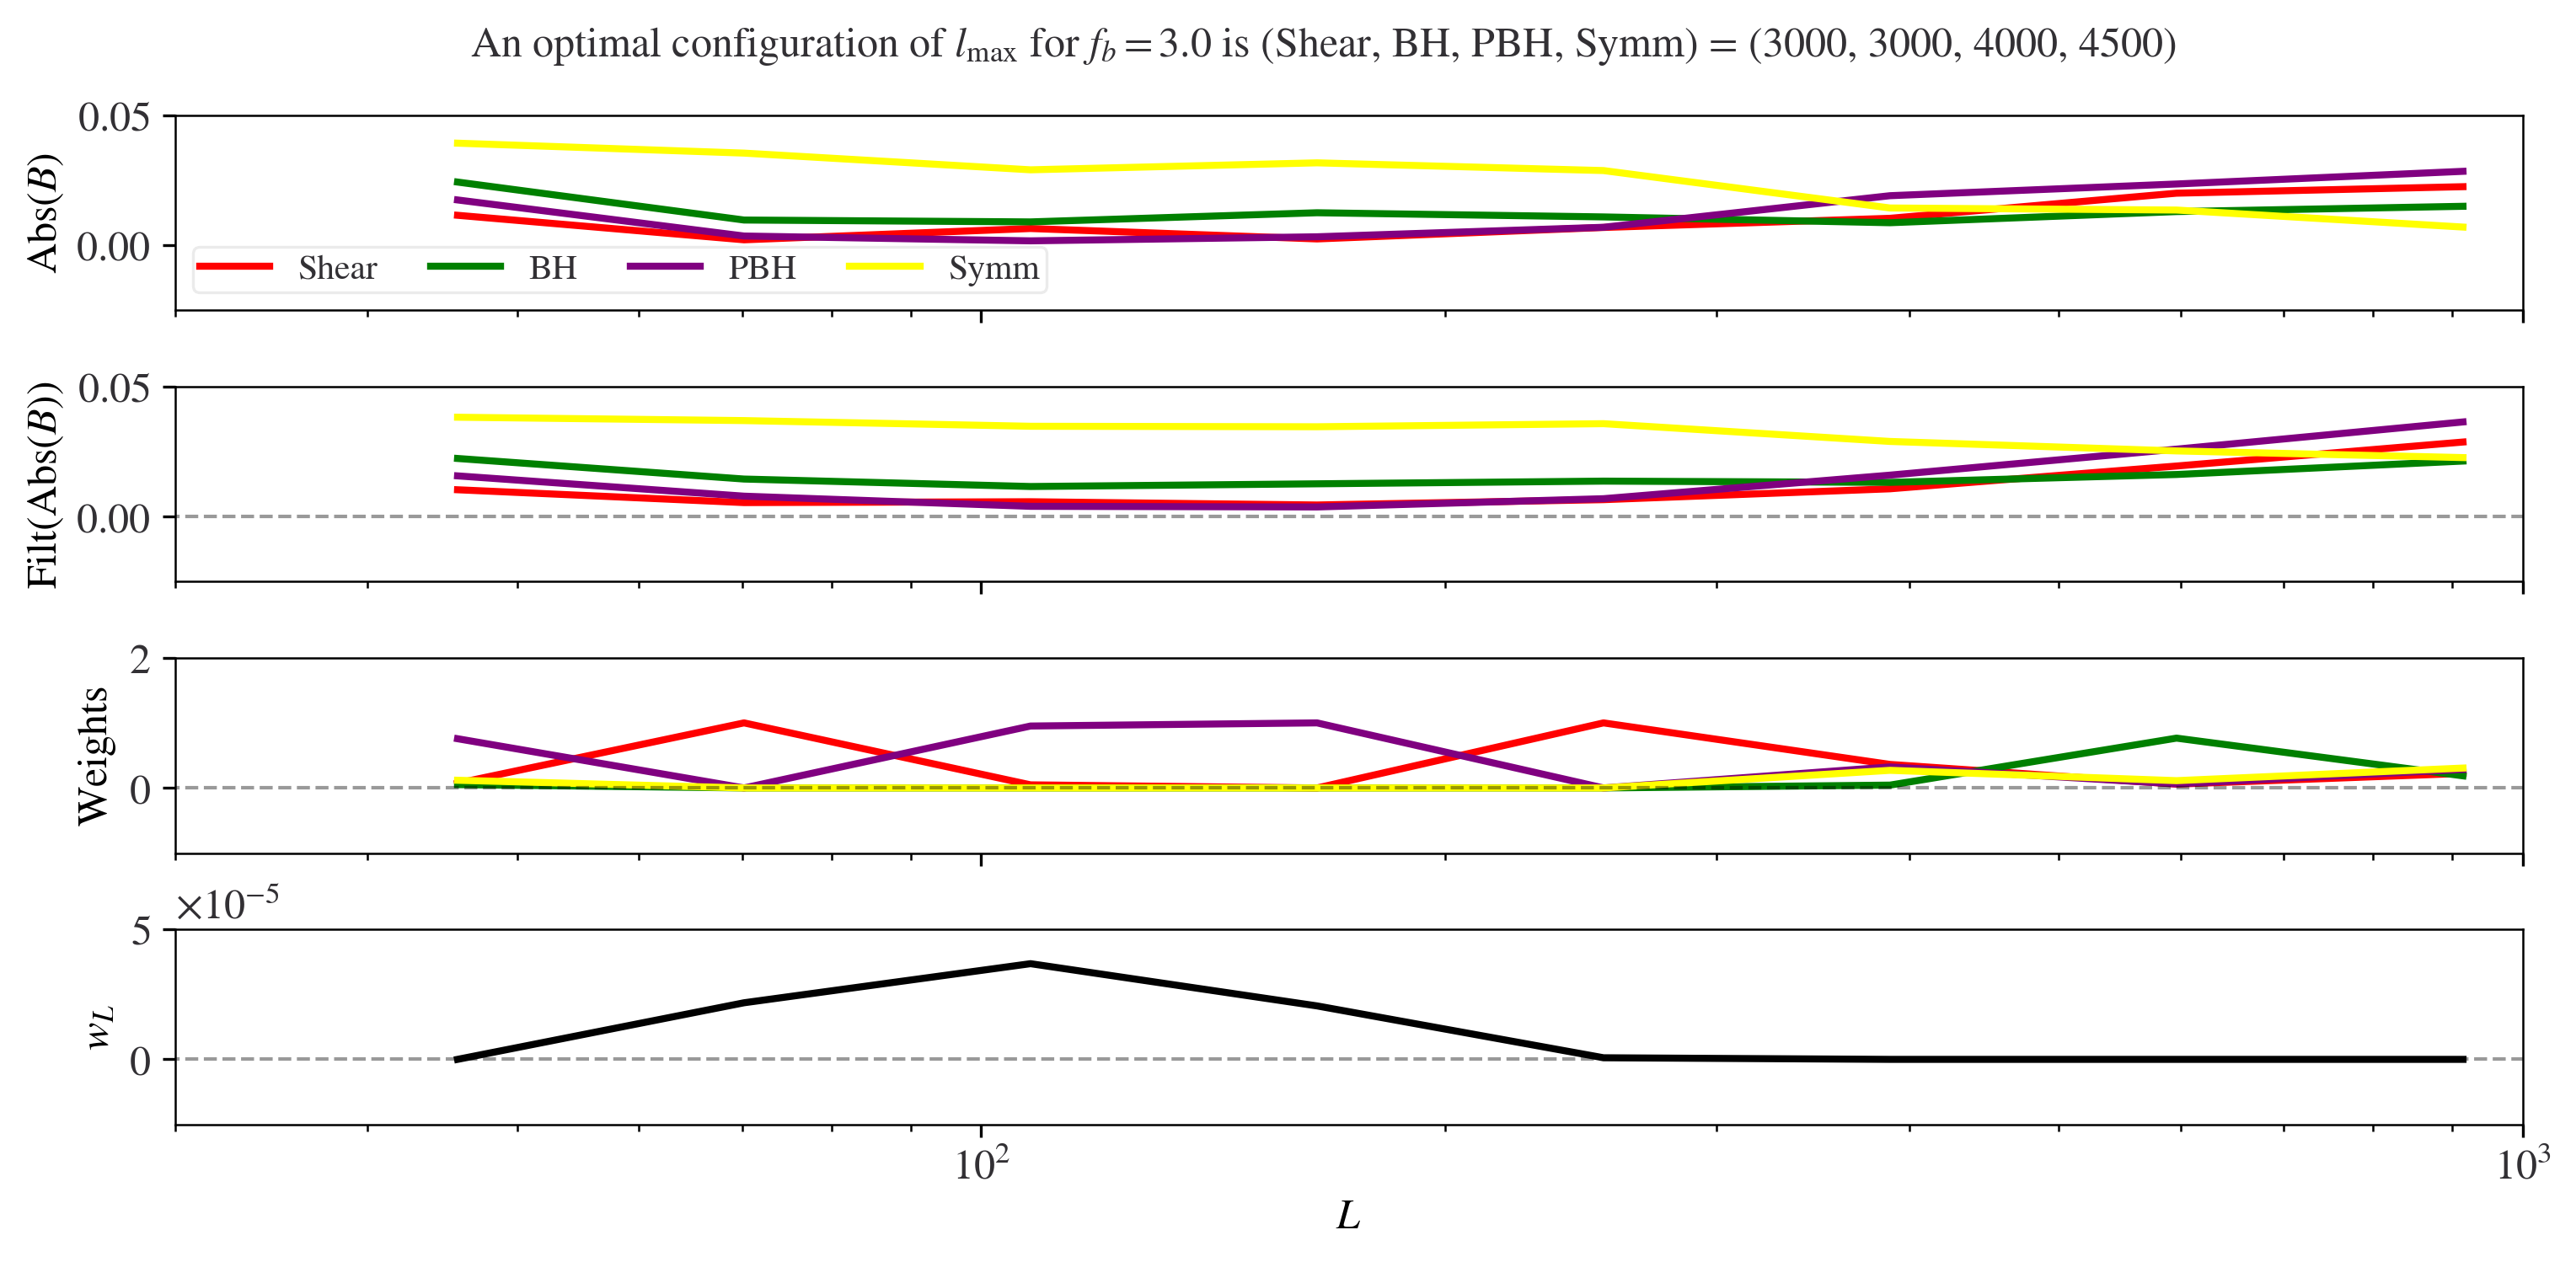

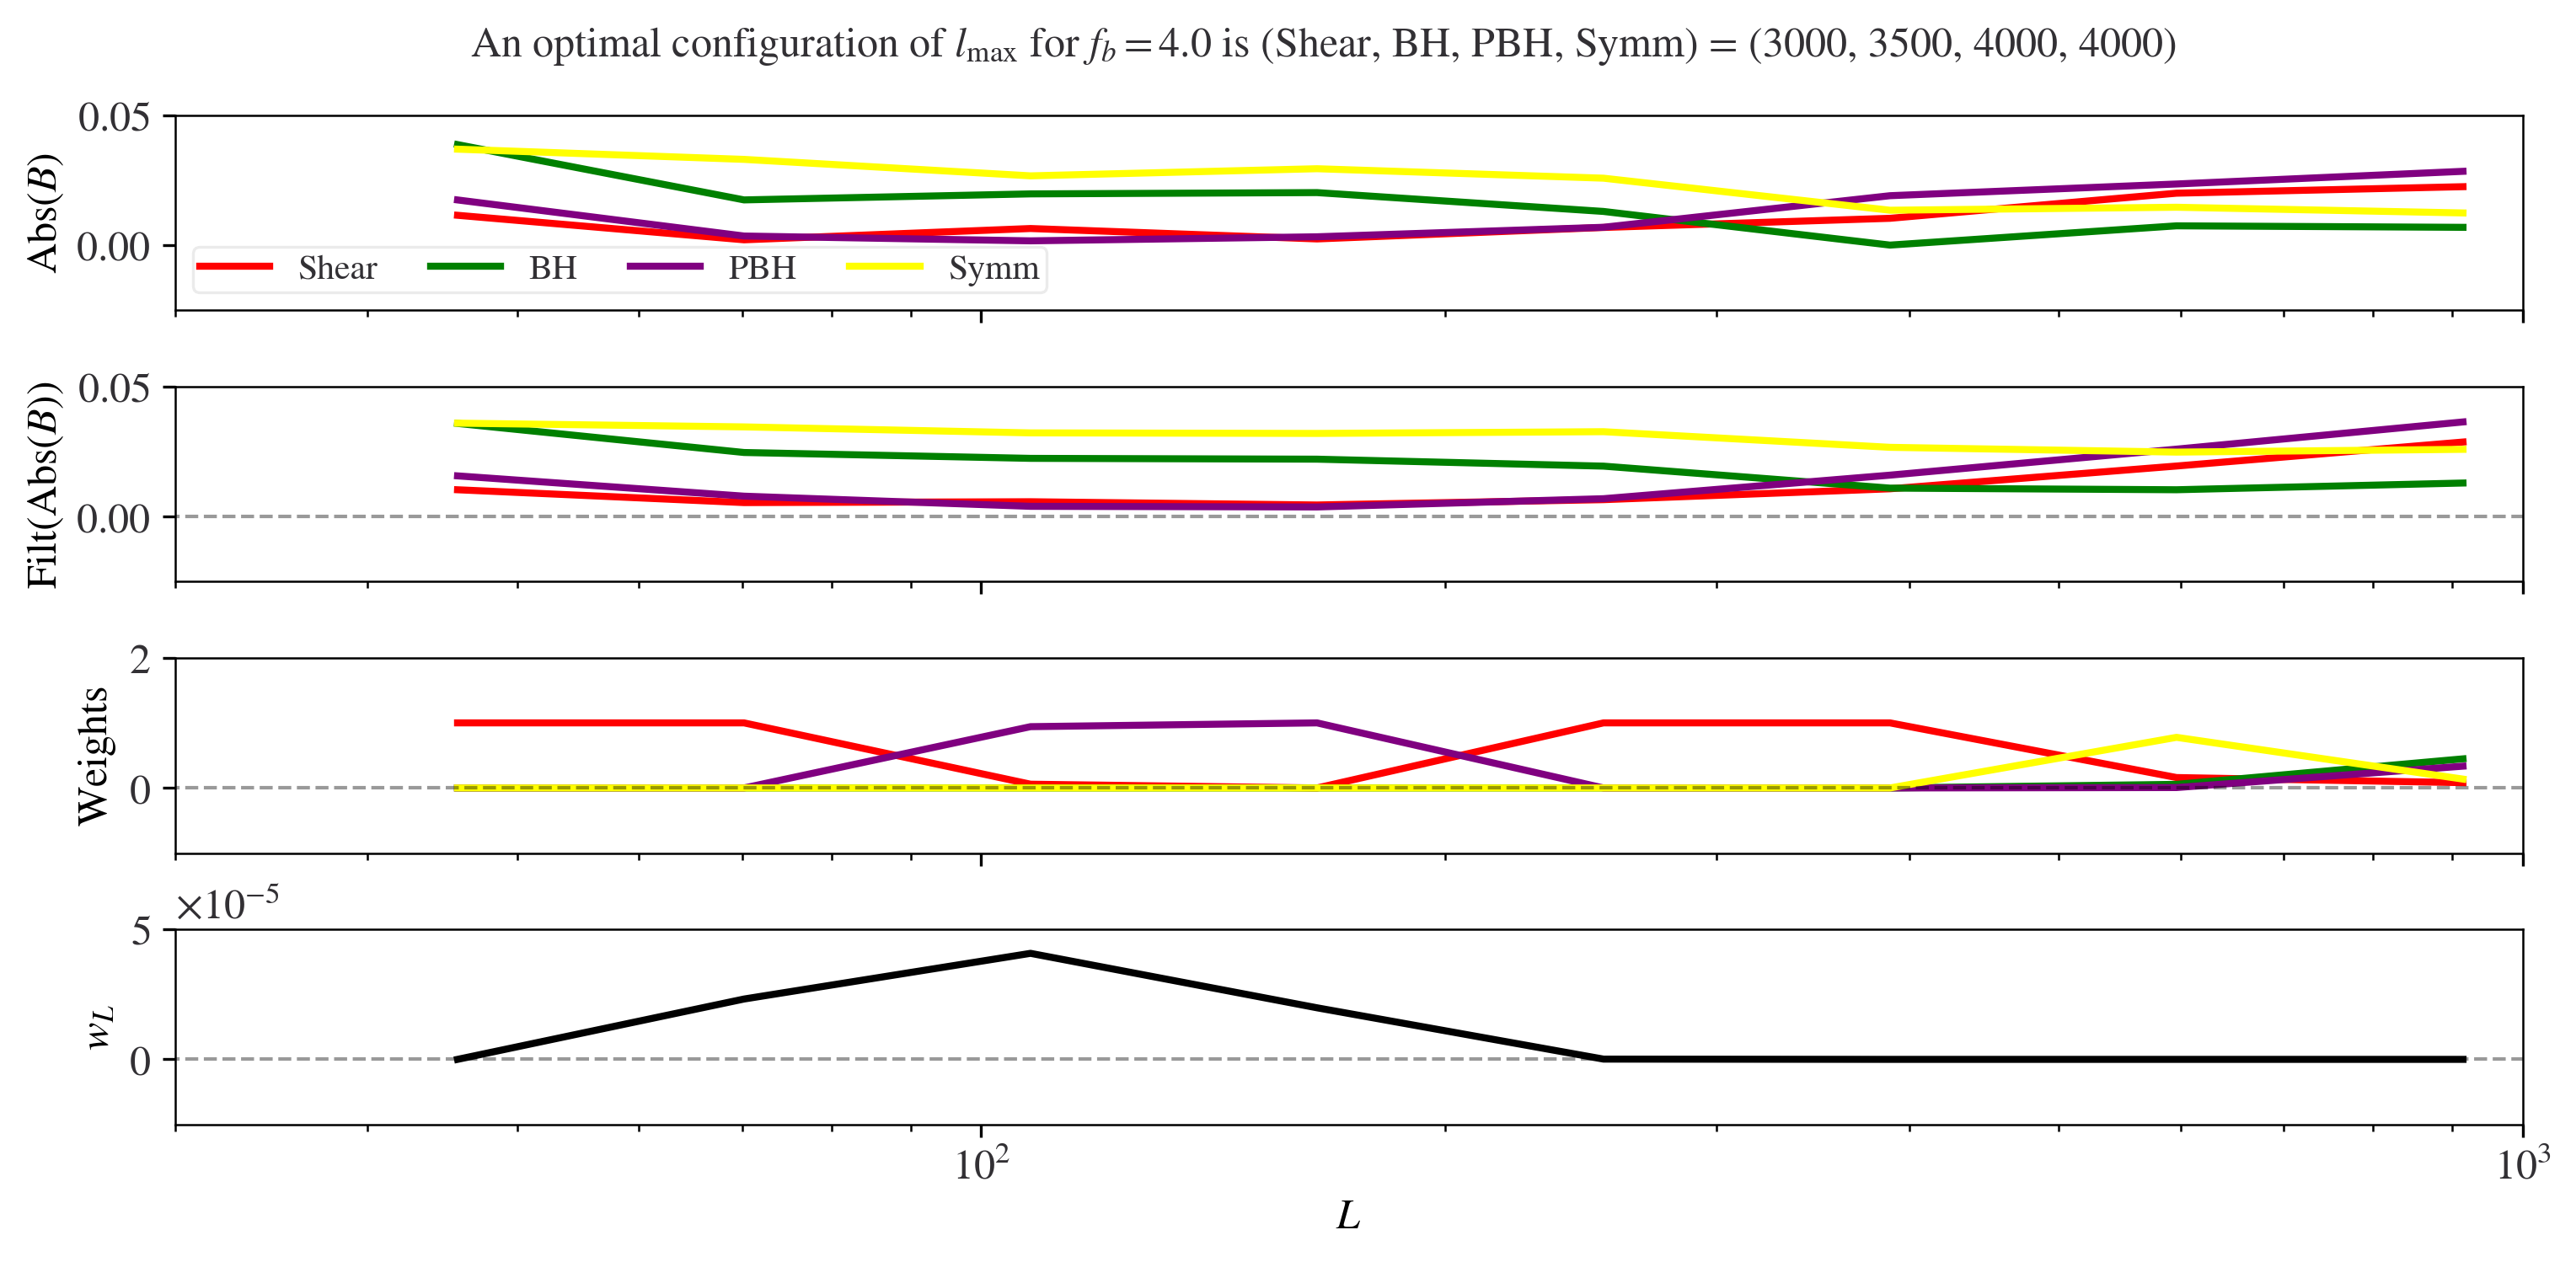

In [449]:
Ndir = len(relevant_directorties)

Nplots = 2
extranumber = 2
extraplots = 3


ns = np.array([])
bs = np.array([])
fs = np.array([])

for i, couple in enumerate(zip(relevant_directorties, fbs)):
    
    lmax_directory, fb = couple
    fbname = np.round(np.sqrt(fb), 2)
    
    lista_numeri = re.findall(r'\d+', lmax_directory)
    superlabel = '('
    superlabelnum = ' = ('
    for i_e, e in enumerate(estimators):
        extra = ', ' if i_e<len(estimators[:-1]) else ''
        superlabel += f'{labeling[e]}{extra}' 
        superlabelnum += f'${lista_numeri[i_e]}${extra}'
        
    superlabel += ')'
    superlabelnum += ')'
        
    superlabel += superlabelnum
    
    lmax_directory = pathlib.Path(lmax_directory)
    
    fig, axs = plt.subplots(nrows = Nplots+extranumber, figsize = (10, 5), sharex = True)

    fig.tight_layout(rect = [0, 0.03, 1, 0.95])
    fig.suptitle('An optimal configuration of $l_{\mathrm{max}}$'+f' for $f_b={fbname}$ is {superlabel}')
    #fig.subplots_adjust(hspace = 0.8)

    
    kk, theta, ells, biases, noises, w, x = get_info(lmax_directory, resultspath, fb = fb)
    Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, abs(biases), noises)
    Ne = Optimizerkk.Ne
    
    for k in range(Optimizerkk.Ne):
        ff = lambda x: abs(x)
        #for j in range(k, Optimizerkk.Ne):
        if fb>0:
            axs[0].plot(Optimizerkk.ells_selected, ff(Optimizerkk.biases_selected[k, k]/Optimizerkk.theory_selected), label = labeling[names_W[k]], color = colors[k])
        elif fb == 0:
            axs[0].plot(Optimizerkk.ells_selected, np.sqrt((Optimizerkk.theta_selected[k, k, k, k]/Optimizerkk.theory_selected**2)**-1), label = labeling[names_W[k]], color = colors[k])
            
        axs[1].plot(Optimizerkk.ells_selected, Optimizerkk.filter_(abs(Optimizerkk.biases_selected), sigma = 1.5)[k, k]/Optimizerkk.theory_selected, color = colors[k])
    
    axs[1].plot(Optimizerkk.ells, Optimizerkk.ells*0., color = 'black', ls = '--', alpha = 0.4, lw = 1)
    axs[0].set_xscale('log')
    axs[1].set_xscale('log')
    
    #print(fb, lmax_directory)
    
    results_array = np.load(resultspath/lmax_directory/f'alens_{fb}{crosstag}{optimtag}.npy')[:, 0]
    ftemp, ntemp, btemp = results_array
    
    bs = np.append(bs, btemp)
    ns = np.append(ns, ntemp)
    fs = np.append(fs, ftemp)
        
    for k in range(Optimizerkk.Ne):
        resultkk = best.Res()
        #d = make_table(resultspath, all_lmaxes_directories, ['BH', 'SYBH', 'PH', 'SY'], fb = fb, include_estimators = False)
        #direc = d.sort_values(by = 'Total Auto').head(1).iloc[0, 0]
        resultkk.load_all(resultspath/lmax_directory, f'auto_fb_{fb}{crosstag}')
        weights = resultkk.ws[:, k]
        weights[weights<1e-5] = 0.
        #print(d.sort_values(by = 'Total Auto').head(1))
        fbname = np.round(np.sqrt(fb), 2)
        label = f'{fbname} {lmax_directory}' if k == 0 else None
        axs[0+extranumber].plot(Optimizerkk.ells_selected, weights, color = colors[k])
        
    axs[0+extranumber].set_ylabel('$\mathrm{Weights}$')
    #axs[0+extranumber].legend(ncol = 2, loc = 'best')
    #axs[0+extranumber].set_xlim(-0.01, 1.1)
    #axs[0+extranumber].set_xscale('log')
    
    wl = resultkk.ws[:, -1]
    axs[1+extranumber].plot(Optimizerkk.ells_selected, wl, color = 'black')
    #axs[1+extranumber].legend(ncol = 1, loc = 'best')
    axs[1+extranumber].set_ylabel('$w_L$')
    
    axs[1+extranumber].set_xlabel('$L$')    
    axs[1+extranumber].set_xscale('log')
    
    axs[0+extranumber].plot(Optimizerkk.ells, Optimizerkk.ells*0., color = 'black', ls = '--', alpha = 0.4, lw = 1)
    axs[1+extranumber].plot(Optimizerkk.ells, Optimizerkk.ells*0., color = 'black', ls = '--', alpha = 0.4, lw = 1)

    if fb > 0:
        axs[0].set_ylabel('$\mathrm{Abs}(B)$')
    elif fb == 0.:
        axs[0].set_ylabel('$\Theta$')
        
    axs[0].legend(ncol = Ne)
    axs[1].set_ylabel('$\mathrm{Filt}(\mathrm{Abs}(B))$')
    fbname = np.sqrt(fb)
    
    axs[-1].set_xlim(30, 1000)
    fig.savefig(output_plots/f'optimalcombs_{fbname}.png')
    plt.show()

### Exploring Optimal Neighbours

In [ ]:
ns = np.array([])
bs = np.array([])
fs = np.array([])

ns_no_filt = np.array([])
bs_no_filt = np.array([])
fs_no_filt = np.array([])


all_best_direcs = []

names_W = list(names)+['$W_L$']
names_W

for ii, fb in enumerate(fbs):
    d = make_table(resultspath, all_lmaxes_directories, ['S', 'BH', 'PH', 'SY'], fb = fb, crosstag = crosstag, optimtag = optimtag, include_estimators = False, extradir = inv_variance_dir)
    
    d_no_filt = make_table(resultspath, all_lmaxes_directories, ['S', 'BH', 'PH', 'SY'], fb = fb, crosstag = crosstag, optimtag = '', include_estimators = False, extradir = inv_variance_dir)
    
    
    dref = make_table(resultspath, all_lmaxes_directories, ['S', 'BH', 'PH', 'SY'], fb = fb, crosstag = crosstag, optimtag = optimtag, all_ref = all_ref,
                      include_estimators = False, extradir = inv_variance_dir, include_ref = True)

    Ntop = 5
    
    print(d.sort_values(by = 'Total Auto').head(Ntop))
    
    print(dref.sort_values(by = 'Total Auto').head(Ntop).iloc[:5, 3:])

    top5 = list(d.sort_values(by = 'Total Auto').head(Ntop).iloc[:Ntop, 0])
    top5_no_filt = list(d_no_filt.sort_values(by = 'Total Auto').head(Ntop).iloc[:Ntop, 0])
    
    direc = d.sort_values(by = 'Total Auto').head(1).iloc[0, 0]
    print(direc)
    lmax_directory = direc
    
    all_best_direcs += [direc]
    
    kk, theta, ells, biases, noises, w, x = get_info(direc, resultspath, fb = fb)
    Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, (biases), noises, nocrosses = nocross)
    
    if optim:
        filtbiases = Optimizerkk.filter_(abs(Optimizerkk.biases_selected), sigma = 1.5)
        Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, Optimizerkk.ells_selected, Optimizerkk.theory_selected, Optimizerkk.theta_selected, filtbiases, Optimizerkk.noises_selected)              
                  
                  
    resultkk = best.Res()
    f, n, b = fnb_getter(Optimizerkk, fb_val = fb, invvar = invvariance)
    resultkk.load_all(resultspath/lmax_directory/inv_variance_dir, f'auto_fb_{fb}{crosstag}')
    
    results_array = np.load(resultspath/direc/f'alens_{fb}{crosstag}{optimtag}.npy')[:, 0]
    ftemp, ntemp, btemp = results_array
    
    print(ntemp, n(resultkk.x))
    
    ns = np.append(ns, ntemp)
    bs = np.append(bs, btemp)
    fs = np.append(fs, ftemp)
    
    smallns = []
    smallbs = []
    
    smallns_no_filt = []
    smallbs_no_filt = []
    for temp_lmax_directory, temp_lmax_directory_no_filt in zip(top5, top5_no_filt):
        results_array = np.load(resultspath/temp_lmax_directory/f'alens_{fb}{crosstag}{optimtag}.npy')[:, 0]
        ftemp, ntemp, btemp = results_array
        
        smallns += [ntemp]
        smallbs += [btemp]
        
        results_array = np.load(resultspath/temp_lmax_directory/f'alens_{fb}{crosstag}.npy')[:, 0]
        ftemp, ntemp, btemp = results_array
        
        smallns_no_filt += [ntemp]
        smallbs_no_filt += [btemp]
        
    smallbs = np.array(smallbs)
    smallns = np.array(smallns)
    
    smallbs_no_filt = np.array(smallbs_no_filt)
    smallns_no_filt = np.array(smallns_no_filt)
        
    fig, ax = plt.subplots(figsize = (10, 10))
    fbname = np.round(np.sqrt(fb), 2)
    fig.suptitle(f'Top five for fb = {fbname}, case of {precisetitle}')
    ax.set_ylabel('$\\sigma(\hat{A})$', size = 20)
    ax.set_xlabel('$abs(b(\hat{A}))$', size = 20)
    for i, c in enumerate(zip(abs(smallbs), smallns)):
        b, n = c
        ax.scatter(b, n, color = colors_plotting[i], label = top5[i])
        
    for i, c in enumerate(zip(abs(smallbs_no_filt), smallns_no_filt)):
        b, n = c
        ax.scatter(b, n, color = colors_plotting[i], label = top5_no_filt[i], alpha = 0.4)
        
    ax.legend()
    ax.axvline(0., ymin = 0, ymax = 1)
    fbname = np.sqrt(fb)
    fig.savefig(output_plots/f'top5_for_{fbname}.png', dpi = 300)
    plt.show()  


                      Name  Total Auto  Noise Auto  Bias Auto
192  s4500b4500p3000sy4500    0.000048    0.006925   0.040123
209  s4500b4500p3500sy4500    0.000048    0.006925   0.040123
18   s4500b4500p4000sy4500    0.000048    0.006925   0.040123
57   s4500b4500p4500sy4500    0.000048    0.006925   0.040123
116  s4000b4500p3000sy4500    0.000048    0.006925   0.040117
     Bias Auto  Noise Auto rtr  Bias Auto rtr
192   0.040123        1.009492       1.419506
209   0.040123        1.009492       1.419506
18    0.040123        1.009492       1.419506
57    0.040123        1.009492       1.419506
116   0.040117        1.009492       1.419321
s4500b4500p3000sy4500
0.006924662578475446 0.006924662578475446
